### Cats vs Dogs dataseti

In [1]:
import tensorflow_datasets as tfds

In [2]:
data_name = 'cats_vs_dogs'

In [3]:
dataset, info = tfds.load(
    data_name,
    split=['train'],
    data_dir="Cats_and_Dogs\\",
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

In [4]:
info

tfds.core.DatasetInfo(
    name='cats_vs_dogs',
    full_name='cats_vs_dogs/4.0.0',
    description="""
    A large set of images of cats and dogs. There are 1738 corrupted images that are dropped.
    """,
    homepage='https://www.microsoft.com/en-us/download/details.aspx?id=54765',
    data_path='Cats_and_Dogs\\cats_vs_dogs\\4.0.0',
    file_format=tfrecord,
    download_size=786.67 MiB,
    dataset_size=689.64 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'image/filename': Text(shape=(), dtype=string),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=23262, num_shards=8>,
    },
    citation="""@Inproceedings (Conference){asirra-a-captcha-that-exploits-interest-aligned-manual-image-categorization,
    author = {Elson, Jeremy and Douceur, John (JD) and Howell, Jon and Saul, Jared},


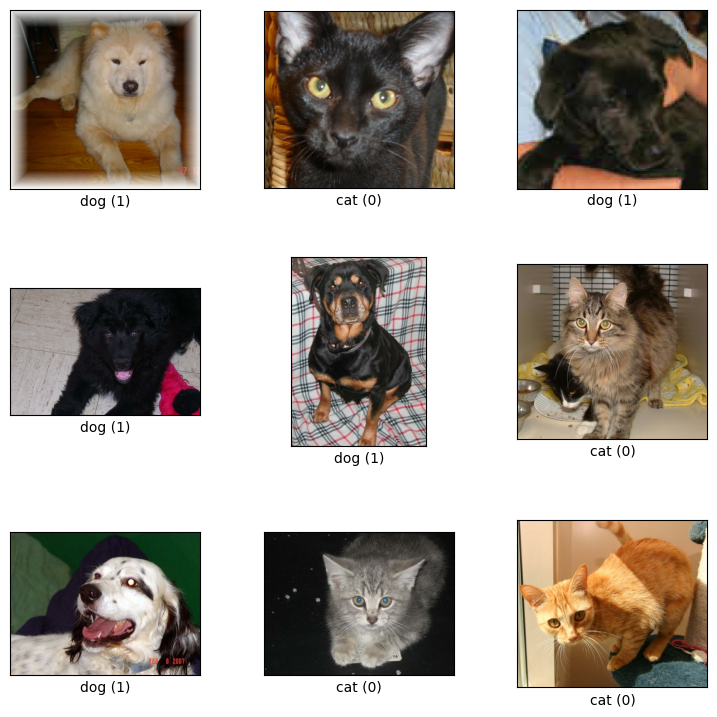

In [5]:
fig = tfds.show_examples(dataset[0], info)

In [6]:
dataset = dataset[0].take(13000)
images,labels = [],[]
for image, label in tfds.as_numpy(dataset):
    images.append(image)
    labels.append(label)

In [7]:
X_train = images[:10000]
X_test = images[10000:]

Y_train = labels[:10000]
Y_test = labels[10000:]

In [8]:
print(f"Train data tarkibidagi 0-class elementlari soni:{Y_train.count(0)}")
print(f"Train data tarkibidagi 1-class elementlari soni:{Y_train.count(1)}")
print(f"Test data tarkibidagi 0-class elementlari soni:{Y_test.count(0)}")
print(f"Test data tarkibidagi 1-class elementlari soni:{Y_test.count(1)}")

Train data tarkibidagi 0-class elementlari soni:4994
Train data tarkibidagi 1-class elementlari soni:5006
Test data tarkibidagi 0-class elementlari soni:1482
Test data tarkibidagi 1-class elementlari soni:1518


In [9]:
import numpy as np
import cv2

In [10]:
def resize(data):
    for i in range(len(data)):
        data[i] = cv2.cvtColor(data[i],cv2.COLOR_BGR2RGB)
        data[i] = np.array(cv2.resize(data[i],(256,256),interpolation = cv2.INTER_AREA))
    return data

X_train = np.array(resize(X_train)).astype('float32')/255.0
X_test = np.array(resize(X_test)).astype('float32')/255.0

Y_train = np.array(Y_train).astype('uint8')
Y_test = np.array(Y_test).astype('uint8')

print(f"X_train shape:{X_train.shape}")
print(f"X_test shape:{X_test.shape}")
print(f"Y_train shape:{Y_train.shape}")
print(f"Y_test shape:{Y_test.shape}")

X_train shape:(10000, 256, 256, 3)
X_test shape:(3000, 256, 256, 3)
Y_train shape:(10000,)
Y_test shape:(3000,)


In [11]:
from tensorflow.keras import Model
import tensorflow as tf

In [12]:
train_ds = tf.data.Dataset.from_tensor_slices((X_train, Y_train)).batch(32)
test_ds = tf.data.Dataset.from_tensor_slices((X_test, Y_test)).batch(32)

In [13]:
class MyModel(Model):
    def __init__(self):
        super(MyModel, self).__init__()
        # Convolution Layer
        self.block1_conv = tf.keras.layers.Conv2D(16, 3, activation=tf.keras.activations.relu, padding="same")
        self.block2_conv = tf.keras.layers.Conv2D(32, 3, activation=tf.keras.activations.relu, padding="same")
        self.block3_conv = tf.keras.layers.Conv2D(64, 3, activation=tf.keras.activations.relu, padding="same")
        self.block4_conv = tf.keras.layers.Conv2D(128, 3, activation=tf.keras.activations.relu, padding="same")
        
        self.pool = tf.keras.layers.MaxPooling2D((2,2))
        
        # Classification Layer
        self.flatten = tf.keras.layers.Flatten()
        
        self.hidden1 = tf.keras.layers.Dense(512, activation=tf.keras.activations.relu)
        self.hidden2 = tf.keras.layers.Dense(256)
        self.hidden3 = tf.keras.layers.Dense(10)
        
        self.output_layer = tf.keras.layers.Dense(2, activation=tf.keras.activations.softmax)
        
    def call(self, x):
        # Block 1
        
        conv1 = self.block1_conv(x) # 256x256x16
        pooling = self.pool(conv1) # 128x128x16
        
        # Block 2
        conv2 = self.block2_conv(pooling) # 128x128x32
        pooling = self.pool(conv2) # 64x64x32
        
        # Block 3
        conv3 = self.block3_conv(pooling) # 64x64x64
        pooling = self.pool(conv3) # 32x32x64
        
        # Block 3
        conv4 = self.block4_conv(pooling) # 32x32x128
        pooling = self.pool(conv4) # 16x16x128
        
        flatten_layer = self.flatten(pooling)
        
        dense1 = self.hidden1(flatten_layer)
        dense2 = self.hidden2(dense1)
        dense3 = self.hidden3(dense2)
        
        return self.output_layer(dense3)

model = MyModel()

In [14]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

optimizer = tf.keras.optimizers.Adam()

In [15]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

In [16]:
@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:

        predictions = model(images, training=True)
        loss = loss_object(labels, predictions)
        
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    train_loss(loss)
    train_accuracy(labels, predictions)

In [17]:
@tf.function
def test_step(images, labels):
    predictions = model(images, training=False)
    t_loss = loss_object(labels, predictions)

    test_loss(t_loss)
    test_accuracy(labels, predictions)

In [18]:
EPOCHS = 5

for epoch in range(EPOCHS):
  # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()

    for images, labels in train_ds:
        train_step(images, labels)

    for test_images, test_labels in test_ds:
        test_step(test_images, test_labels)

    print(
    f'** {epoch + 1}-epoch:\n '
    f'Loss: {train_loss.result()}, '
    f'Accuracy: {train_accuracy.result() * 100}\n'
    f'Test Loss: {test_loss.result()}, '
    f'Test Accuracy: {test_accuracy.result() * 100}')

c:\users\airi\appdata\local\programs\python\python38\lib\site-packages\keras\backend.py:5585: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


** 1-epoch:
 Loss: 0.7152616381645203, Accuracy: 52.82999801635742
Test Loss: 0.6861428618431091, Test Accuracy: 54.633331298828125
** 2-epoch:
 Loss: 0.6440401673316956, Accuracy: 62.529998779296875
Test Loss: 0.618806779384613, Test Accuracy: 64.83332824707031
** 3-epoch:
 Loss: 0.5520240664482117, Accuracy: 71.97999572753906
Test Loss: 0.5313697457313538, Test Accuracy: 73.4000015258789
** 4-epoch:
 Loss: 0.48427414894104004, Accuracy: 76.70000457763672
Test Loss: 0.5298810005187988, Test Accuracy: 74.76666259765625
** 5-epoch:
 Loss: 0.41664397716522217, Accuracy: 81.05000305175781
Test Loss: 0.5620904564857483, Test Accuracy: 74.5999984741211


In [19]:
model.summary()

Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             multiple                  448       
                                                                 
 conv2d_1 (Conv2D)           multiple                  4640      
                                                                 
 conv2d_2 (Conv2D)           multiple                  18496     
                                                                 
 conv2d_3 (Conv2D)           multiple                  73856     
                                                                 
 max_pooling2d (MaxPooling2D  multiple                 0         
 )                                                               
                                                                 
 flatten (Flatten)           multiple                  0         
                                                          

In [20]:
model.save('Model')

INFO:tensorflow:Assets written to: Model\assets


INFO:tensorflow:Assets written to: Model\assets


### Modelni sinovdan o'tkazamiz 

In [1]:
from tensorflow.keras.models import load_model
model = load_model('Model') 

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

#### Dog sinfi uchun misol

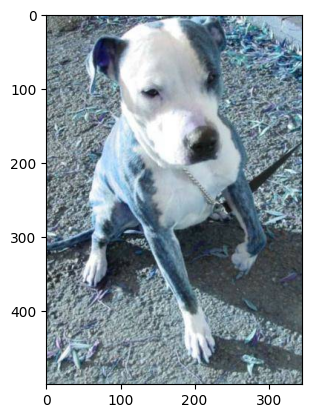

In [3]:
image_dog = cv2.imread("Cats_and_Dogs\examples\cats_vs_dogs (102).jpg")
plt.imshow(image_dog)

In [4]:
image_dog = np.array(cv2.resize(image_dog,(256,256),interpolation = cv2.INTER_AREA))
image_dog = np.array(image_dog).astype('float32')/255.0

In [5]:
image_dog.shape

(256, 256, 3)

In [6]:
image = image_dog.reshape(1,256,256,3)

In [7]:
one_hot_encoding_label = model.predict(image)

1/1 [==============================] - 0s 157ms/step


In [8]:
one_hot_encoding_label

array([[0.05604521, 0.94395477]], dtype=float32)

In [9]:
if np.argmax(one_hot_encoding_label)==1:
    print("Dog")
    
else:
    print("Cat")

Dog


#### Cat sinfi uchun misol

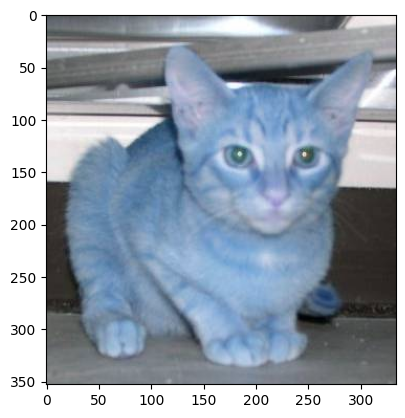

In [10]:
image_cat = cv2.imread("Cats_and_Dogs\examples\cats_vs_dogs (97).jpg")
plt.imshow(image_cat)

In [11]:
image_cat = np.array(cv2.resize(image_cat,(256,256),interpolation = cv2.INTER_AREA))
image_cat = np.array(image_cat).astype('float32')/255.0

In [12]:
image_cat.shape

(256, 256, 3)

In [13]:
image = image_cat.reshape(1,256,256,3)

In [14]:
one_hot_encoding_label = model.predict(image)

1/1 [==============================] - 0s 41ms/step


In [15]:
one_hot_encoding_label

array([[0.7799646 , 0.22003531]], dtype=float32)

In [16]:
if np.argmax(one_hot_encoding_label)==1:
    print("Dog")
    
else:
    print("Cat")

Cat
